In [ ]:
%pip install openai langchain PyPDF2 pypdf
%pip install -U langchain-community
%pip install python-dotenv

In [97]:
import os
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

## PDF 바탕으로 1차로 전처리 후 txt로 저장. 
## 그 txt 파일을 바탕으로 답변 생성

(정확도 증가)

### Full text를 다 넣어줬을 때 (카테고라이징 전)

In [ ]:
question = "원가계산체계정의 과정에서 원가계산단위를 어떻게 설정하나요?"

with open("preprocessed.txt", 'r', encoding='utf-8') as txt_file:
        pdf_text = txt_file.read()

prompt = f"""
질문: {question}

문서 내용:{pdf_text}

"""

response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "문서 내용을 참고해서 질문에 대해 답변해주세요."},
            {"role": "user", "content": prompt}
        ]
    )

print("답변: " + response.choices[0].message.content)

### 카테고라이징 후

문서 전처리

In [ ]:
import re

# 카테고리 생성 함수
def generate_categorized_txt(input_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    prompt = f"""
    # 목표
    - 문서의 주요 내용을 파악하여 논리적인 목차를 구성합니다.
    - 목차는 계층적으로 구성되며, 최대 2단계까지 세분화됩니다.
    - 일관된 포맷을 유지해야 합니다.

    # 출력 형식
    출력은 다음과 같은 형식을 따라야 합니다.
    1. [대주제] 1.1 [중주제]

    # 지침
    - 제목을 최대한 간결하게 작성합니다.
    - 중복되는 내용을 배제하고, 문서의 핵심 내용을 반영합니다.
    - 문서의 흐름을 고려하여 논리적인 순서로 정리합니다.

    # 입력
    다음은 분석할 Markdown 문서입니다:

    {content}

    # 출력 예시
    1. 원가계산체계정의
        1.1 원가계산기준
        1.2 원가구조 및 원가계정체계
        1.3 표준재고단가등록
        1.4 제품재투입단가등록/제품이동단가등록

    # 출력
    (여기에 목차를 출력)
    ...
    """

    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[ 
                {"role": "system", "content": "당신은 문서 분석을 전문으로 하는 AI입니다. 주어진 Markdown 파일의 내용을 기반으로 정확하고 논리적인 목차를 생성하세요."},
                {"role": "user", "content": prompt}
            ],
            temperature = 0.2
        )

    table_of_contents = response.choices[0].message.content

    output_file_path = "document/categorized.md"
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(table_of_contents)

    return table_of_contents

In [ ]:
input_file_path = "document/example.md"
generate_categorized_txt(input_file_path)

'```\n1. ERP-IU 소개\n    1.1 ERP-IU란?\n    1.2 시스템 운영환경\n    1.3 ERP-IU 기술 정보\n    1.4 ERP-IU 회계 메뉴 구성도\n    1.5 ERP-IU 기능 소개\n    1.6 ERP-IU Client 프로그램 설치\n    1.7 프로그램 작업순서\n\n2. 시스템 관리\n    2.1 시스템 현황정보\n        2.1.1 DD 관리\n        2.1.2 자료 IMPORT\n        2.1.3 다국어 입력\n    2.2 시스템 기준정보\n        2.2.1 코드관리\n        2.2.2 자동채번등록\n        2.2.3 통제환경설정관리\n        2.2.4 환율정보등록\n        2.2.5 리포트 관리 등록\n        2.2.6 시스템 환경설정\n        2.2.7 도움창 환경설정\n        2.2.8 회계환경설정\n    2.3 거래처 정보\n        2.3.1 거래처정보관리\n        2.3.2 거래처조회\n        2.3.3 거래처정보 변경내역\n    2.4 시스템 권한정보\n        2.4.1 그룹정보 등록\n        2.4.2 사용자정보 등록\n        2.4.3 권한관리\n        2.4.4 그룹메뉴 관리\n        2.4.5 사용자 메뉴관리\n        2.4.6 세부권한 환경설정\n        2.4.7 사용자별 세부권한\n        2.4.8 처리버튼 권한설정\n        2.4.9 환경설정 권한등록\n\n3. 회계기준정보\n    3.1 기초자료 등록\n        3.1.1 예적금계좌등록\n        3.1.2 신용카드등록\n        3.1.3 사업자등록번호\n        3.1.4 휴일정보등록\n    3.2 계정설정\n        3.2.1 계정등록\n        3.2.2 관리항목등록\n        3.2.3 관리내역등록\n        

In [ ]:
# 파일의 내용을 불러오는 함수
def load_data_from_file(filename):
    texts = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            text = line.strip()
            if text:
                texts.append(text)
    return texts

In [ ]:
categories = load_data_from_file("document/categorized.md")

def select_tag_from_category(categories):
    prompt = f"""

    # 목표
    - 목차의 최상위 레벨(1단계) 항목을 태그로 변환합니다.
    - 태그는 **반드시** 최상위 항목의 제목을 그대로 사용해야 합니다.
    - 태그는 str 형식으로 반환되어야 합니다.

    # 입력
    다음은 목차입니다:
    {categories}

    # 출력 형식
    - 태그는 반드시 아래 형식을 따라야 합니다.
    ["1. 최상위 항목1", "2. 최상위 항목2", "3. 최상위 항목3"]

    # 예시
    ## 입력
    카테고리:
    1. 대학교
        1.1 입학 준비
        1.2 학과 소개
    2. 중학교
        2.1 학생 지원
        2.2 교육과정
    3. 교육정책
        3.1 교육과정 개편
        3.2 교육과정 평가
    4. 입시제도
        4.1 입시제도 개편
        4.2 입시제도 평가
    
    ## 출력
    ["1. 대학교", "2. 중학교", "3. 교육정책", "4. 입시제도"]

    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "당신은 문서 분석을 전문으로 하는 AI입니다. 주어진 목차를 분석하여 최상위 항목을 기반으로 태그를 생성해야 합니다."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

tags = select_tag_from_category(categories)
print(tags)

["1. ERP-IU 소개", "2. 시스템 관리", "3. 회계기준정보", "4. 재무관리", "5. 건별 반제관리", "6. 외화관리", "7. 재무제표 관리", "8. 결산관리", "9. 손익관리", "10. 원가관리", "11. 배부관리"]


### 사용자 질문에서 관련 카테고리 추출

In [125]:
# 사용자가 질문을 입력하면 해당 카테고리 항목을 반환하는 함수
def score_tag_for_question(question):

    prompt = f"""
    # 목표
    - 사용자의 질문을 분석하여 핵심 주제를 파악합니다.
    - 주어진 카테고리를 바탕으로 모든 태그에 대해 0~100 사이로 점수를 매깁니다. 

    # 입력
    사용자의 질문과 카테고리 및 태그 목록이 주어집니다.

    질문: {question}
    
    카테고리: {categories}
    태그: {tags}

    # 평가 기준
    - 관련성 (40점): 사용자의 질문과 가장 관련성이 높은 태그를 선택했는가?
    - 의미적 유사도 (30점): 질문의 의도가 해당 태그와 유사한가?
    - 논리적 적절성 (30점): 태그가 질문의 문맥과 논리적으로 일관되는가?
    
    # 출력 형식
    태그명1: 85
    태그명2: 60
    태그명3: 95

    # 지침
    - 반드시 모든 태그에 대해 점수를 매겨야합니다.

    # 예시
    ## 입력
    질문: "대학교 입학 준비는 어떻게 하면 좋을까요?"

    카테고리:
    1. 대학교
        1.1 입학 준비
        1.2 학과 소개
    2. 중학교
        2.1 학생 지원
        2.2 교육과정
    3. 교육정책
        3.1 교육과정 개편
        3.2 교육과정 평가
    4. 입시제도
        4.1 입시제도 개편
        4.2 입시제도 평가
    태그: ["1. 대학교", "2. 중학교", "3. 교육정책", "4. 입시제도"]

    ## 출력
    1. 대학교: 85
    2. 중학교: 50
    3. 교육정책: 75
    4. 입시제도: 90

    """
    
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "당신은 사용자의 질문과 미리 정의된 카테고리를 비교하여 가장 적절한 태그를 선택하는 AI입니다. 반드시 제공된 태그 중에서만 선택해야 합니다."},
                {"role": "user", "content": prompt}
            ],
            temperature = 0.2
        )
    
    response_text = response.choices[0].message.content

    # 모델의 응답을 기반으로 해당 카테고리 항목을 반환
    return response_text

In [126]:
# 예시 질문
question = "집계는 되지 않으며 다음 기수로 이월되지 않는 관리항목 코드는 무엇인가요?"
tag_score = score_tag_for_question(question)
print(tag_score)

집계는 되지 않으며 다음 기수로 이월되지 않는 관리항목 코드는 무엇인가요?

1. ERP-IU 소개: 40
2. 시스템 관리: 80
3. 회계기준정보: 90
4. 재무관리: 60
5. 건별 반제관리: 30
6. 외화관리: 20
7. 재무제표 관리: 70
8. 결산관리: 50
9. 손익관리: 85
10. 원가관리: 25
11. 배부관리: 15


In [127]:
def filter_high_scores(text: str, threshold: int = 80):
    high_scores = []
    
    matches = re.findall(r"(.+?): (\d+)", text)
    
    for subject, score in matches:
        if int(score) >= threshold:
            high_scores.append((subject, int(score)))
    
    high_scores.sort(key=lambda x: x[1], reverse=True)
    
    return [subject for subject, score in high_scores]

text = tag_score
category_answer = filter_high_scores(text)


In [129]:
print(category_answer)

['3. 회계기준정보', '9. 손익관리', '2. 시스템 관리']


In [124]:
import json, ast

def get_text_by_tags(json_file: str, selected_tags: list):

    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    selected_texts = {tag: data[tag] for tag in selected_tags if tag in data}

    return selected_texts

In [130]:
json_file_path = "document/splitted.json"
selected_tags_list = category_answer

extracted_texts = get_text_by_tags(json_file_path, selected_tags_list)
    
for tag, text in extracted_texts.items():
    print(f"### {tag} ###\n{text}\n")

### 3. 회계기준정보 ###
1. 기초자료 등록 1) 예적금계좌등록 예금·적금을 가입한 경우 본 화면에서 등록하고 관련 정보 등을 관리하는 화면이다. 예적금 등록 은 초기설정시 이루어져야 전표입력시 계좌 별 입출금 내역을 입력할 수 있다.  예적금 코드: 코드를 숫자 20 자리 이내로 입력한다. (필수)  예적금 구분: 당좌, 예금, 적금중에서 선택한다.  이자계산방식: 단리와 복리의 예적금 이자계산 방식을 입력한다.  회계단위: 해당 예적금 계좌를 사용할 회계단위를 입력한다.  환종구분: 외화통장인 경우 해당되는 통화 종류를 입력한다.  금융기관: 해당 금융기관을 입력한다. 입력하고자 할 경우 금융기관 코드번호를 직접 입 력하고 엔터를 누르거나 물음표 아이콘를 클릭하여 선택한다.  차월한도액: 당좌차월 한도액을 입력한다. 90  최초불입액: 적금인 경우 입력한다.  만기계약 이자: 예적금 만기금액을 입력한다.  계정코드: 보통예금, 당좌예금, 제예금, 정기적금 등 계정과목을 입력한다. 회계환경설정의 ‘예적금 도움창 회계계정 필터’ 설정 값이 ‘사용’ 일 때 동작한다. 이는 전표입력시 회계계정에 연결된 예적금계좌만 보여지도록 하는 기능이다.  사용여부: 사용중인 통장이면 'YES', 사용하지 않는 통장은 'NO'로 입력한다.  적요: 비고사항을 입력한다.  납입주기: 예적금 납입주기를 월단위로 입력한다.  자금코드: 자금수지관리의 일자금 계획에 적금을 반영하고자 할 경우 해당되는 자금코드 를 입력한다.  예산사업계획: 해당 예적금에 관련된 예산사업계획이 있는 경우 설정한다.  예적금을 입력하고자 할 경우 (추가) 버튼을 누르면 오른쪽에 입력화면이 나타난다.  계좌번호부터 차례대로 해당 자료를 입력하고 (저장) 버튼을 누른다  해당 예적금 계좌의 금융기관과 계정코드를 반드시 입력한다. 91 2) 신용카드등록 회사가 보유하고 있는 신용카드를 등록하고 관리하기 위한 메뉴이다.  신용카드번호: 실제로 사용하는 신용카드번호를 입력한

### 최종 답변 생성

용어집 참여하고 답변

In [131]:
def load_glossary(glossary_file: str):

    with open(glossary_file, "r", encoding="utf-8") as f:
        glossary = json.load(f)
    return glossary

glossary_file = "glossary.json"
glossary = load_glossary(glossary_file)

In [134]:
def generate_answer(question, input_text, glossary):
    prompt = f"""
    # 목표
    - 사용자 질문을 분석하여 핵심 정보를 파악합니다.
    - 제공된 문서에서 관련 내용을 찾아 정확하고 구체적인 답변을 제공합니다.
    - 문서에 해당 내용이 없을 경우, "제공된 문서에는 해당 정보가 없습니다."라고 응답하세요.
    - 전문 용어가 필요할 경우, 제공된 용어집을 참고하여 적절한 용어를 사용하세요.
    - 응답 형식은 간결하지만, 필요하면 세부적인 정보를 포함해야 합니다.

    # 제약 사항
    - 문서에 있는 정보만 사용하여 답변하세요.
    - 불확실한 정보는 생성하지 마세요.
    - 질문과 직접적으로 관련된 문서 내용을 인용하여 답변을 작성하세요.

    # 용어집
    아래는 전문 용어의 정의입니다.  
    필요할 경우 적절한 용어를 사용하여 답변을 작성하세요.
    {glossary}

    # 입력 문서
    다음은 사용자가 제공한 문서 내용입니다.
    {input_text}

    # 사용자의 질문 
    {question}
    
    """
    
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "당신은 사용자가 제공한 문서를 기반으로 질문에 답하는 AI 비서입니다. 답변을 작성할 때 반드시 주어진 문서의 내용을 바탕으로 하며, 문서에 없는 정보는 절대 생성하지 마십시오. 또한, 전문 용어가 필요할 경우 제공된 용어집을 참고하여 정확한 용어를 사용하십시오"},
                {"role": "user", "content": prompt}
            ],
            temperature = 0.2 
        )
    
    response_text = response.choices[0].message.content
    print(response_text)

    # 모델의 응답을 기반으로 해당 카테고리 항목을 반환
    return response_text

In [135]:
final_answer = generate_answer(question, extracted_texts, glossary)

제공된 문서에 따르면, 집계는 되지 않으며 다음 기수로 이월되지 않는 관리항목 코드는 'B'로 시작하는 관리항목입니다. 'B'타입의 관리항목은 주로 자산, 자금, 세무관리에서 사용됩니다.


## 멀티 모달

In [ ]:
pip install matplotlib


In [143]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Matplotlib is building the font cache; this may take a moment.


In [144]:
png_images = load_data_from_file("image_tag.md")

# 사용자가 질문을 입력하면 해당 카테고리 항목을 반환하는 함수
def select_image(question):

    prompt = f"""
    
    # 목표
    - 사용자가 제공한 질문을 이해하고 핵심 내용을 파악합니다.
    - 이미지 리스트에서 질문과 가장 연관성이 높은 이미지를 찾습니다.
    - 선택한 이미지의 태그를 반환합니다.
    - 적절한 이미지가 없을 경우, "None"을 반환합니다.

    # 이미지 태그 예시
    ["1. 이미지1", "2. 이미지2", "3. 이미지3", "4. 이미지4", "5. 이미지5"]

    # 출력 형식
    - 관련 이미지가 있을 경우: 
    ["3. 이미지3", "5. 이미지5"]
    - 관련 이미지가 없을 경우: 
    ["None"]

    # 사용자 질문
    {question}

    # 이미지 태그
    {png_images}

    """
    
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "당신은 이미지 데이터베이스에서 사용자의 질문과 가장 관련성이 높은 이미지를 찾는 AI 비서입니다. 당신의 목표는 질문에 가장 적합한 이미지를 식별하고 해당 이미지의 태그를 반환하는 것입니다."},
                {"role": "user", "content": prompt}
            ]
        )
    
    response_text = response.choices[0].message.content
    print(response_text)

    # 모델의 응답을 기반으로 해당 카테고리 항목을 반환
    return response_text


In [149]:
question = "Data Dictionary의 목적이 무엇인가요?"
image = select_image(question)
image = ast.literal_eval(image)

["1. Data Dictionary"]


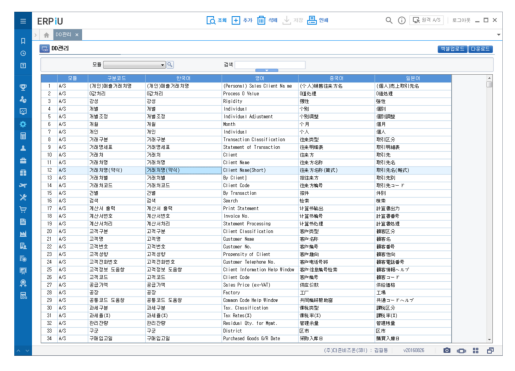

In [ ]:
image_filenames = [f"image/{title}.png" for title in image]

for image_path in image_filenames:
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Image file '{image_path}' not found.")

# 결론

### 프롬프트 구체적으로 작성하면 성능 좋다